In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
import importlib
from pathlib import Path
import re

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d
from torch.nn import SiLU as ReLU
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch

from dataset import *
from utils import *
from ResNet18_blocks import *
from ResNet50_blocks import *
from training_functions import *

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
from Overfeat import OverFeat

In [4]:
#volume_dir = "/mnt/shared_volume/"
volume_dir = "/mnt/home/u0053/disk/gaia_dataset/CompCars/"

In [5]:
# create folder inside volume dir 
for vp in range(6):
    if not os.path.exists(volume_dir + f'{vp}/'):
        os.makedirs(volume_dir + f'{vp}/')

In [6]:
! ls /mnt/shared_volume/data/train_test_split/classification

ls: cannot access '/mnt/shared_volume/data/train_test_split/classification': No such file or directory


In [7]:
label_to_index = indexing_labels(volume_dir+"data/train_test_split/classification/train.txt")
print("Nr of models in the train dataset: ", len(label_to_index))

Nr of models in the train dataset:  431


In [8]:
transforms_train = Compose([
    Resize((224, 224)), 
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [15]:
make_dataset = dataset_factory(volume_dir, label_to_index, transforms_train, transforms) # serve per creare la factory che genera i dataset
VIEWPOINT = 1
train_dataset, test_dataset, valid_dataset =  make_dataset(VIEWPOINT) # carino perchè devi passare solo il viewpoint

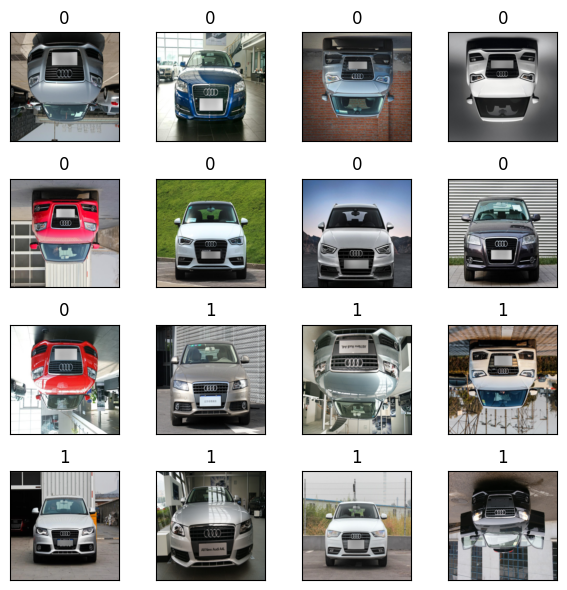

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()

In [11]:
print(f'train dataset: {len(train_dataset)} \ntest dataset: {len(test_dataset)} \nvalid dataset: {len(valid_dataset)}')

train dataset: 16016 
test dataset: 7576 
valid dataset: 7363


In [12]:
# Here we use the Dataloader function from pytorch to opportunely split the dataset in batches and shuffling data
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = OverFeat()
optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=5e-4)
loss = CrossEntropyLoss
epochs = 50


In [17]:
train_loss_log, val_loss_log, _ = network_training(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    load_checkpoint=load_checkpoint(
        load=False, 
        model=model,
        opt=Adam(params=model.parameters(), lr=3e-4, weight_decay=5e-4), 
        device=device, 
        volume_dir=volume_dir
    ),
    loss_fn=fix_losses(calcul_class_weights(train_dataloader), CrossEntropyLoss, device),
    device=device,
    epochs=epochs,
    save_checkpoint=lambda model, opt: save_checkpoint(model, opt, VIEWPOINT or "0", volume_dir),
    save_metric=lambda metric, values: store_metric(volume_dir)(metric, values, VIEWPOINT)
)

Epoch: 1


100%|██████████| 39/39 [00:06<00:00,  5.68it/s]


loss: 6.065889835357666, accuracy: 0.0027162840124219656
Model and optimizer state saved.
Epoch: 2


100%|██████████| 39/39 [00:07<00:00,  5.19it/s]


loss: 6.065879821777344, accuracy: 0.003395355073735118
Model and optimizer state saved.
Epoch: 3


100%|██████████| 39/39 [00:06<00:00,  5.93it/s]


loss: 6.065919876098633, accuracy: 0.003395355073735118
Epoch: 4


100%|██████████| 39/39 [00:06<00:00,  5.72it/s]


loss: 6.065882682800293, accuracy: 0.0027162840124219656
Epoch: 5


100%|██████████| 39/39 [00:06<00:00,  6.23it/s]


loss: 6.06585693359375, accuracy: 0.003395355073735118
Model and optimizer state saved.
Epoch: 6


100%|██████████| 39/39 [00:06<00:00,  5.92it/s]


loss: 6.065840721130371, accuracy: 0.0027162840124219656
Model and optimizer state saved.
Epoch: 7


100%|██████████| 39/39 [00:07<00:00,  5.33it/s]


loss: 6.0657758712768555, accuracy: 0.0027162840124219656
Model and optimizer state saved.
Epoch: 8


100%|██████████| 39/39 [00:06<00:00,  6.27it/s]


loss: 6.065711498260498, accuracy: 0.003395355073735118
Model and optimizer state saved.
Epoch: 9


100%|██████████| 39/39 [00:06<00:00,  6.44it/s]


loss: 6.065679550170898, accuracy: 0.0009506994392722845
Model and optimizer state saved.
Epoch: 10


100%|██████████| 39/39 [00:06<00:00,  6.16it/s]


loss: 6.065629005432129, accuracy: 0.0042102402076125145
Model and optimizer state saved.
Epoch: 11


100%|██████████| 39/39 [00:06<00:00,  6.40it/s]


loss: 6.065582752227783, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 12


100%|██████████| 39/39 [00:06<00:00,  6.34it/s]


loss: 6.0655436515808105, accuracy: 0.004617683123797178
Model and optimizer state saved.
Epoch: 13


100%|██████████| 39/39 [00:07<00:00,  5.02it/s]


loss: 6.065511703491211, accuracy: 0.004617683123797178
Model and optimizer state saved.
Epoch: 14


100%|██████████| 39/39 [00:06<00:00,  5.74it/s]


loss: 6.065478801727295, accuracy: 0.002987912390381098
Model and optimizer state saved.
Epoch: 15


100%|██████████| 39/39 [00:06<00:00,  6.24it/s]


loss: 6.065445899963379, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 16


100%|██████████| 39/39 [00:06<00:00,  6.46it/s]


loss: 6.065400123596191, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 17


100%|██████████| 39/39 [00:07<00:00,  5.05it/s]


loss: 6.065397262573242, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 18


100%|██████████| 39/39 [00:06<00:00,  5.97it/s]


loss: 6.065370082855225, accuracy: 0.003938612062484026
Model and optimizer state saved.
Epoch: 19


100%|██████████| 39/39 [00:06<00:00,  6.31it/s]


loss: 6.06535005569458, accuracy: 0.005975824780762196
Model and optimizer state saved.
Epoch: 20


100%|██████████| 39/39 [00:06<00:00,  6.05it/s]


loss: 6.065298080444336, accuracy: 0.003938612062484026
Model and optimizer state saved.
Epoch: 21


100%|██████████| 39/39 [00:06<00:00,  5.69it/s]


loss: 6.06528902053833, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 22


100%|██████████| 39/39 [00:06<00:00,  6.31it/s]


loss: 6.065239906311035, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 23


100%|██████████| 39/39 [00:06<00:00,  6.23it/s]


loss: 6.065250873565674, accuracy: 0.004617683123797178
Epoch: 24


100%|██████████| 39/39 [00:06<00:00,  5.81it/s]


loss: 6.0652360916137695, accuracy: 0.009506993927061558
Model and optimizer state saved.
Epoch: 25


100%|██████████| 39/39 [00:06<00:00,  6.26it/s]


loss: 6.065224647521973, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 26


100%|██████████| 39/39 [00:07<00:00,  5.18it/s]


loss: 6.065167427062988, accuracy: 0.009506993927061558
Model and optimizer state saved.
Epoch: 27


100%|██████████| 39/39 [00:08<00:00,  4.77it/s]


loss: 6.065155029296875, accuracy: 0.004889311268925667
Model and optimizer state saved.
Epoch: 28


100%|██████████| 39/39 [00:06<00:00,  5.71it/s]


loss: 6.065115928649902, accuracy: 0.0042102402076125145
Model and optimizer state saved.
Epoch: 29


100%|██████████| 39/39 [00:06<00:00,  6.09it/s]


loss: 6.065094470977783, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 30


100%|██████████| 39/39 [00:07<00:00,  5.25it/s]


loss: 6.0651021003723145, accuracy: 0.009099551476538181
Epoch: 31


100%|██████████| 39/39 [00:06<00:00,  6.04it/s]


loss: 6.0650835037231445, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 32


100%|██████████| 39/39 [00:06<00:00,  6.22it/s]


loss: 6.065047264099121, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 33


100%|██████████| 39/39 [00:06<00:00,  6.15it/s]


loss: 6.065060615539551, accuracy: 0.009099551476538181
Epoch: 34


100%|██████████| 39/39 [00:06<00:00,  6.18it/s]


loss: 6.065033912658691, accuracy: 0.004617683123797178
Model and optimizer state saved.
Epoch: 35


100%|██████████| 39/39 [00:06<00:00,  6.01it/s]


loss: 6.064959526062012, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 36


100%|██████████| 39/39 [00:06<00:00,  5.76it/s]


loss: 6.064991474151611, accuracy: 0.009099551476538181
Epoch: 37


100%|██████████| 39/39 [00:06<00:00,  6.34it/s]


loss: 6.064883708953857, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 38


100%|██████████| 39/39 [00:07<00:00,  5.10it/s]


loss: 6.06489372253418, accuracy: 0.009099551476538181
Epoch: 39


100%|██████████| 39/39 [00:06<00:00,  6.12it/s]


loss: 6.064871311187744, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 40


100%|██████████| 39/39 [00:06<00:00,  6.18it/s]


loss: 6.0648980140686035, accuracy: 0.009099551476538181
Epoch: 41


100%|██████████| 39/39 [00:07<00:00,  5.25it/s]


loss: 6.06493616104126, accuracy: 0.004617683123797178
Epoch: 42


100%|██████████| 39/39 [00:06<00:00,  6.15it/s]


loss: 6.064935684204102, accuracy: 0.009099551476538181
Epoch: 43


100%|██████████| 39/39 [00:07<00:00,  5.02it/s]


loss: 6.064863204956055, accuracy: 0.004617683123797178
Model and optimizer state saved.
Epoch: 44


100%|██████████| 39/39 [00:06<00:00,  5.62it/s]


loss: 6.064833164215088, accuracy: 0.009099551476538181
Model and optimizer state saved.
Epoch: 45


100%|██████████| 39/39 [00:07<00:00,  5.34it/s]


loss: 6.064820766448975, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 46


100%|██████████| 39/39 [00:06<00:00,  5.88it/s]


loss: 6.064770221710205, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 47


100%|██████████| 39/39 [00:07<00:00,  5.15it/s]


loss: 6.064743518829346, accuracy: 0.006519082002341747
Model and optimizer state saved.
Epoch: 48


100%|██████████| 39/39 [00:06<00:00,  5.72it/s]


loss: 6.064764499664307, accuracy: 0.009099551476538181
Epoch: 49


100%|██████████| 39/39 [00:06<00:00,  6.26it/s]


loss: 6.064781665802002, accuracy: 0.009506993927061558
Epoch: 50


100%|██████████| 39/39 [00:06<00:00,  5.85it/s]

loss: 6.064810752868652, accuracy: 0.004617683123797178
